# Triage network workflow

In [1]:
%load_ext autoreload
%autoreload 2

## Part 1. Train/Test set creation

In [23]:
import datetime
import logging
from pathlib import Path
from os.path import expanduser
from os import path

import yass
from yass import read_config
from yass.augment import make
from yass.neuralnetwork import NeuralNetTriage
from yass.batch import RecordingsReader
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index


import seaborn as sns
import numpy as np
from dstools import plot
import sklearn_evaluation.plot as skplot

# logging.basicConfig(level=logging.DEBUG)

In [3]:
path_to_data = expanduser('~/data')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')

In [4]:
yass.set_config("../../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

### 1.1 Loading templates

In [5]:
raw_templates = np.load(Path(path_to_data, 'cat/templates-jul27-only-good.npy'))
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [6]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


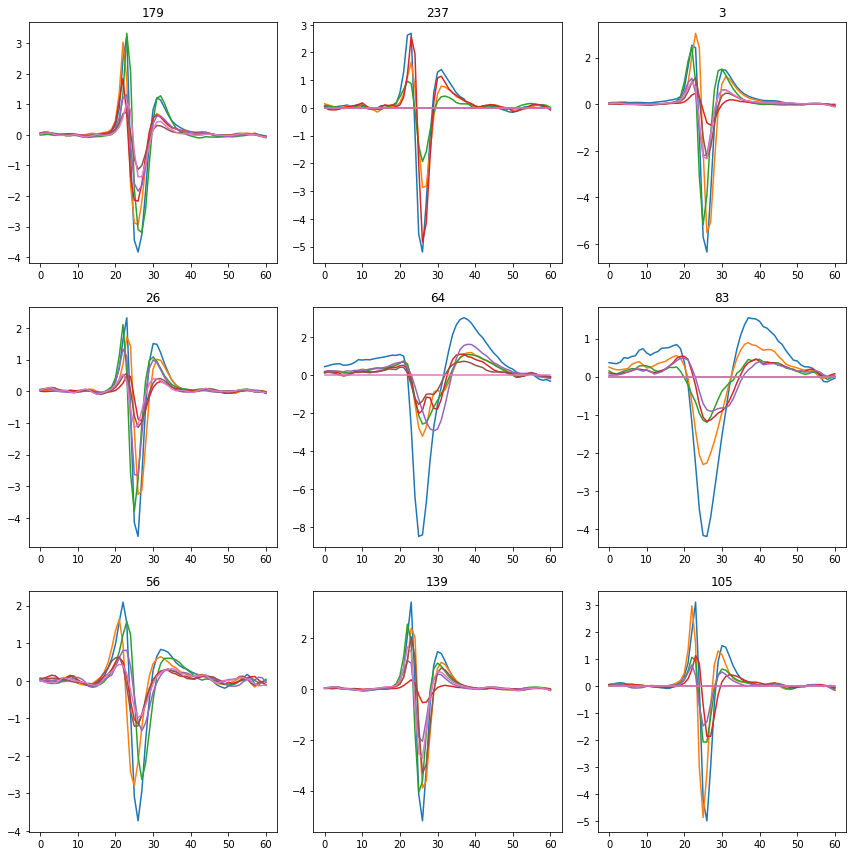

In [7]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

### 1.2 Estimating noise covariance structure

In [8]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [9]:
rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

### 1.3 Make dataset

In [10]:
min_amplitude = 4
max_amplitude = 60

n_clean_per_template = 150
n_collided_per_spike = 1
max_shift = 15
min_shift = 4

probabilities = (0.8, 0.05, 0.05, 0.05, 0.05)

In [18]:
X, y = make.training_data_triage(templates,
                                       min_amplitude,
                                       max_amplitude,
                                       n_clean_per_template,
                                       n_collided_per_spike,
                                       max_shift,
                                       min_shift,
                                       spatial_sig,
                                       temporal_sig,
                                       {'probabilities': probabilities},
                                       {'return_metadata': True})

In [19]:
X.shape, y.shape

((72000, 61, 7), (72000,))

### 1.4 Plot some examples

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


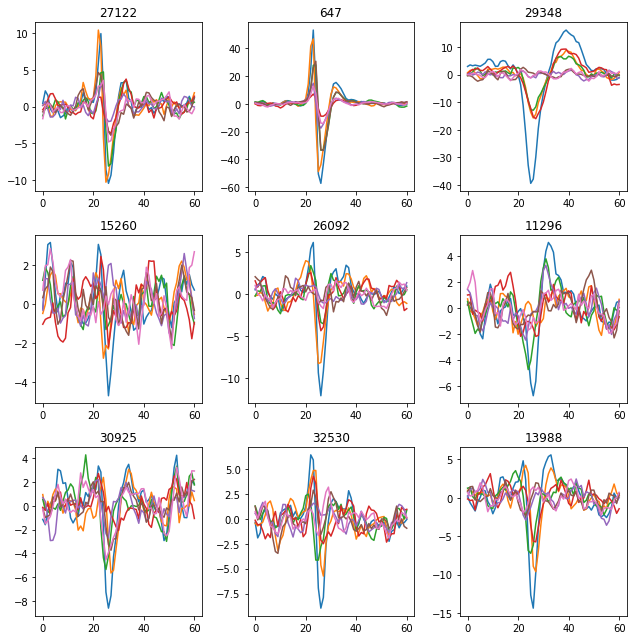

In [20]:
# positive examples: single spikes
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9, auto_figsize=3)

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


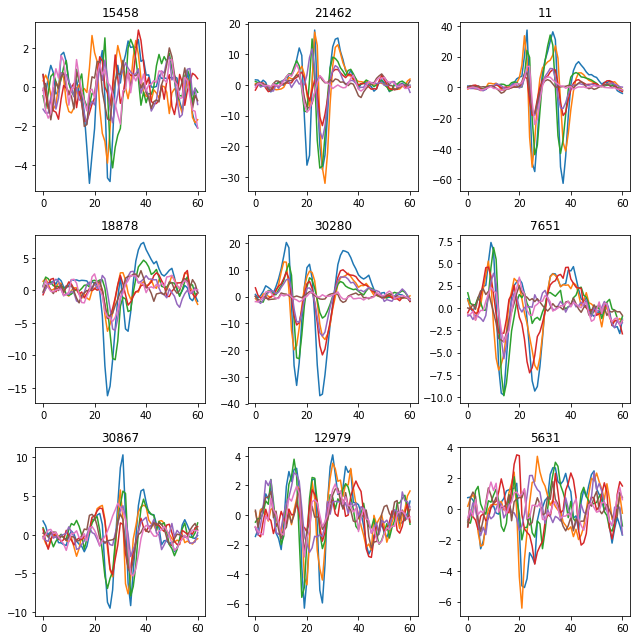

In [22]:
# negative examples: collisions
plot.grid_from_array(X[y == 0], axis=0,
                     elements=9, auto_figsize=3)

## Part 2. Network training

In [28]:
filters_size = [64, 32]
threshold = 0.5
_, waveform_length, n_neighbors =  X.shape

model = NeuralNetTriage('/tmp/my-triage-network.ckpt', filters_size,
                        waveform_length, n_neighbors, threshold,
                        n_iter=5000, n_batch=512, l2_reg_scale=0.00000005,
                        train_step_size=0.001)

In [29]:
model.fit(X, y)


Tr loss: 0.018075604, Val loss: 0.036311846:  21%|██        | 1049/5000 [00:07<00:29, 131.96it/s]


Tr loss: 0.0072195577, Val loss: 0.036508452:  42%|████▏     | 2102/5000 [00:15<00:21, 134.94it/s]


Tr loss: 0.004593426, Val loss: 0.040032893:  63%|██████▎   | 3170/5000 [00:23<00:13, 136.31it/s]


Tr loss: 0.0026701333, Val loss: 0.04448752:  84%|████████▍ | 4212/5000 [00:30<00:05, 136.73it/s]


Tr loss: 0.0014550262, Val loss: 0.0494581: 100%|██████████| 5000/5000 [00:36<00:00, 137.07it/s]

{'filters_size': [64, 32],
 'waveform_length': 61,
 'n_neighbors': 7,
 'name': 'my-triage-network',
 'tn': 0.988248357546035,
 'fp': 0.011766885944593719,
 'fn': 0.010548718423244193,
 'tp': 0.9894375984434356,
 'acc': 0.9888425925925926,
 'prec': 0.9882472700351657,
 'rec': 0.9894375984434356,
 'metadata': {'yass_version': '8575bfd fixes make collided'}}

### Part 3. Network evaluation

In [30]:
preds = model.predict(model.x_test)

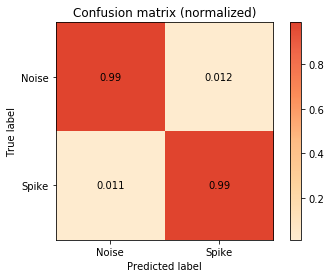

In [32]:
skplot.confusion_matrix(model.y_test, preds, normalize=True, target_names=['Noise', 'Spike'])